In [34]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [35]:
import sys
from pathlib import Path

# Add the parent directory of the notebook to the Python path
sys.path.append(str(Path().resolve().parent))

In [36]:
from funcs.data_read import (
    read_txn_data, 
    read_ob_data,
)

from funcs.preprocess import (
    preprocess_ob_data, 
    preprocess_trx_data,
)

from funcs.features import (
    create_features_order_book,
    create_features_trx,
)

from funcs.utils import (
    filter_extremes,
    deseason_total_volume,
)


In [37]:
ob_data=read_ob_data(test=True,test_size=2)
trx_data=read_txn_data(test=True,test_size=2)
# preprocess the data
preprocess_trx_data=preprocess_trx_data(trx_data,"5min")
preprocess_ob_data=preprocess_ob_data(ob_data,freq="5min")
# create features 
ob_features=create_features_order_book(preprocess_ob_data)
trx_features=create_features_trx(preprocess_trx_data)


Processing 2 file(s): ['C:\\Users\\peter\\codes\\ml\\eth\\Komplex\\data\\bitstamp_ob_04_07_2018.zip', 'C:\\Users\\peter\\codes\\ml\\eth\\Komplex\\data\\bitstamp_ob_04_08_2018.zip']
Processing bitstamp_ob_04_07_2018.zip...
Processing bitstamp_ob_04_08_2018.zip...
Finished loading. Total rows: 49,188,752


C:\Users\peter\codes\ml\eth\Komplex\gitfolder_2\funcs\preprocess.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['side'] = df['side'].astype(str).str.strip().str.lower()
C:\Users\peter\codes\ml\eth\Komplex\gitfolder_2\funcs\preprocess.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['side'] = df['side'].replace(side_mapping)


Side column standardized successfully.
Timestamp ID created successfully.
TRX data resampled to 5min frequency - 38017 transactions grouped into common time windows
Missing values handled successfully.
TRX Data Preprocessed Successfully.
Timestamp ID created successfully.
Resampled OB data to 5min frequency. Selected 4918860 rows.
Missing values handled successfully.
OB Data Preprocessed Successfully.


In [38]:
trx_features = deseason_total_volume(trx_features)

Deseasoned total volume column added successfully.


### AGAIN the merge is not correct as we work with smaller frames - times are not maching

In [39]:
merged_features = ob_features.merge(trx_features, left_index=True, right_index=True, how='inner', suffixes=('', '_trx'))


#### Log Transform

In [40]:
merged_features['log_deseasoned_total_volume'] = np.log(merged_features['deseasoned_total_volume'] + 1e-07)
merged_features = merged_features.dropna()

c:\Users\peter\anaconda3\envs\IML2024\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
merged_features

,timestamp_id,datetime,mid_price,spread,ask_volume,bid_volume,volume_imbalance,ask_slope_10pct,ask_slope_1pct,ask_slope_5pct,...,min_price,buy_volume,sell_volume,total_volume,volume_imbalance_trx,buy_transactions,sell_transactions,transaction_imbalance,deseasoned_total_volume,log_deseasoned_total_volume
0,1530655474,2018-07-03 22:04:34+00:00,6611.895,5.87,2497.541916,567126.769785,564629.227869,1003.547817,317.156398,834.039734,...,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,4.336679,1.467109
1,1530655774,2018-07-03 22:09:34+00:00,6617.420,1.12,2486.359822,567134.623144,564648.263322,992.990295,322.213788,824.110509,...,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,6.236082,1.830352
2,1530656074,2018-07-03 22:14:34+00:00,6608.695,4.31,2506.696883,567135.993855,564629.296973,1012.724015,336.712405,842.590582,...,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,28.051193,3.334031
3,1530656374,2018-07-03 22:19:34+00:00,6606.220,5.04,2495.223606,567141.604644,564646.381038,1001.092725,284.582178,831.030124,...,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,27.529115,3.315244
4,1530656674,2018-07-03 22:24:34+00:00,6597.420,7.14,2514.452154,567133.911995,564619.459841,1031.934433,313.983889,847.275419,...,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,9.684735,2.270551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,1533414874,2018-08-04 20:34:34+00:00,6986.235,0.51,3533.235100,609287.674245,605754.439145,878.414599,233.054383,558.823782,...,6312.20,4.557148,16.930645,21.487793,-12.373497,30.0,24.0,6.0,6.472003,1.867486
560,1533415473,2018-08-04 20:44:33+00:00,6978.905,0.01,3533.408467,609583.717677,606050.309211,876.660584,220.265784,550.603624,...,6311.04,7.250149,6.130703,13.380853,1.119446,16.0,10.0,6.0,4.117437,1.415231
569,1533418174,2018-08-04 21:29:34+00:00,6999.210,0.96,3485.545610,609704.171247,606218.625637,862.509720,227.531603,541.533379,...,6291.11,2.396806,3.207877,5.604683,-0.811071,20.0,19.0,1.0,2.503899,0.917849
571,1533418774,2018-08-04 21:39:34+00:00,7010.680,2.66,3465.881312,609750.948539,606285.067227,850.419458,204.204726,532.551923,...,6301.39,20.268265,0.103193,20.371457,20.165072,37.0,5.0,32.0,6.750438,1.909607


### Lag and drop temporary variables

In [42]:
# drop desesoned_total_volume and lag everything but log_deseasoned_total_volume
merged_features = merged_features.drop(columns=['deseasoned_total_volume'])
#everything but log_deseasoned_total_volume is lagged by 1
for col in merged_features.columns:
    if col != 'log_deseasoned_total_volume':
        merged_features[col] = merged_features[col].shift(1)
# drop NaN values
merged_features = merged_features.dropna()

In [ ]:
merged_features.col

,timestamp_id,datetime,mid_price,spread,ask_volume,bid_volume,volume_imbalance,ask_slope_10pct,ask_slope_1pct,ask_slope_5pct,...,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance_trx,buy_transactions,sell_transactions,transaction_imbalance,log_deseasoned_total_volume
1,1.530655e+09,2018-07-03 22:04:34+00:00,6611.895,5.87,2497.541916,567126.769785,564629.227869,1003.547817,317.156398,834.039734,...,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,1.830352
2,1.530656e+09,2018-07-03 22:09:34+00:00,6617.420,1.12,2486.359822,567134.623144,564648.263322,992.990295,322.213788,824.110509,...,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,3.334031
3,1.530656e+09,2018-07-03 22:14:34+00:00,6608.695,4.31,2506.696883,567135.993855,564629.296973,1012.724015,336.712405,842.590582,...,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,3.315244
4,1.530656e+09,2018-07-03 22:19:34+00:00,6606.220,5.04,2495.223606,567141.604644,564646.381038,1001.092725,284.582178,831.030124,...,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,2.270551
5,1.530657e+09,2018-07-03 22:24:34+00:00,6597.420,7.14,2514.452154,567133.911995,564619.459841,1031.934433,313.983889,847.275419,...,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,2.343043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,1.533413e+09,2018-08-04 20:04:34+00:00,6995.955,5.53,3532.598206,609266.953721,605734.355516,890.148639,222.319626,566.698784,...,6330.00,6320.16,2.469279,12.181496,14.650774,-9.712217,23.0,22.0,1.0,1.867486
560,1.533415e+09,2018-08-04 20:34:34+00:00,6986.235,0.51,3533.235100,609287.674245,605754.439145,878.414599,233.054383,558.823782,...,6330.43,6312.20,4.557148,16.930645,21.487793,-12.373497,30.0,24.0,6.0,1.415231
569,1.533415e+09,2018-08-04 20:44:33+00:00,6978.905,0.01,3533.408467,609583.717677,606050.309211,876.660584,220.265784,550.603624,...,6321.67,6311.04,7.250149,6.130703,13.380853,1.119446,16.0,10.0,6.0,0.917849
571,1.533418e+09,2018-08-04 21:29:34+00:00,6999.210,0.96,3485.545610,609704.171247,606218.625637,862.509720,227.531603,541.533379,...,6305.34,6291.11,2.396806,3.207877,5.604683,-0.811071,20.0,19.0,1.0,1.909607


- We use the first $70 \%$ of points for training, the next $10 \%$ for validation, and the last $20 \%$ of points for out-of-sample testing.

GBM is the gradient boosting machine [60]. It has been empirically proven to be highly effective in predictive tasks across different machine learning challenges $[61,62]$ and more recently in finance [63,64]. The feature vector fed into GBM is also the concatenation of features from order book and transaction data of two markets. The hyper-parameters [65] of GBM are selected by random search in the ranges: number of trees in $[100, \cdots, 1000]$, max number of features used by individual trees in $[1.0, \cdots, 0.1]$, minimum number of samples of the leaf nodes in $[2, \cdots, 9]$, maximum depth of individual trees in $[4, \cdots, 9]$, and the learning rate in $[0.05, \cdots, 0.005]$.

In [48]:
X

,mid_price,spread,ask_volume,bid_volume,volume_imbalance,ask_slope_10pct,ask_slope_1pct,ask_slope_5pct,bid_slope_10pct,bid_slope_1pct,...,max_price,min_price,buy_volume,sell_volume,total_volume,volume_imbalance_trx,buy_transactions,sell_transactions,transaction_imbalance,log_deseasoned_total_volume
1,6611.895,5.87,2497.541916,567126.769785,564629.227869,1003.547817,317.156398,834.039734,1690.065971,263.047038,...,7544.79,7530.81,21.423777,1.636557,23.060334,19.787220,37.0,19.0,18.0,1.830352
2,6617.420,1.12,2486.359822,567134.623144,564648.263322,992.990295,322.213788,824.110509,1697.339460,244.968080,...,7554.98,7537.29,9.751193,1.612293,11.363486,8.138900,25.0,5.0,20.0,3.334031
3,6608.695,4.31,2506.696883,567135.993855,564629.296973,1012.724015,336.712405,842.590582,1753.454619,264.657267,...,7550.00,7530.89,19.376157,21.216462,40.592619,-1.840305,29.0,32.0,-3.0,3.315244
4,6606.220,5.04,2495.223606,567141.604644,564646.381038,1001.092725,284.582178,831.030124,1759.105408,287.466218,...,7542.59,7530.45,23.865826,28.319601,52.185427,-4.453774,41.0,14.0,27.0,2.270551
5,6597.420,7.14,2514.452154,567133.911995,564619.459841,1031.934433,313.983889,847.275419,1751.626559,293.526621,...,7556.74,7537.90,8.860846,10.916385,19.777231,-2.055538,64.0,31.0,33.0,2.343043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,6995.955,5.53,3532.598206,609266.953721,605734.355516,890.148639,222.319626,566.698784,1692.111899,260.251548,...,6330.00,6320.16,2.469279,12.181496,14.650774,-9.712217,23.0,22.0,1.0,1.867486
560,6986.235,0.51,3533.235100,609287.674245,605754.439145,878.414599,233.054383,558.823782,1720.599070,291.244385,...,6330.43,6312.20,4.557148,16.930645,21.487793,-12.373497,30.0,24.0,6.0,1.415231
569,6978.905,0.01,3533.408467,609583.717677,606050.309211,876.660584,220.265784,550.603624,2041.743627,317.355255,...,6321.67,6311.04,7.250149,6.130703,13.380853,1.119446,16.0,10.0,6.0,0.917849
571,6999.210,0.96,3485.545610,609704.171247,606218.625637,862.509720,227.531603,541.533379,2124.820068,291.381823,...,6305.34,6291.11,2.396806,3.207877,5.604683,-0.811071,20.0,19.0,1.0,1.909607


DataFrame shape: (280, 30)
Columns: Index(['timestamp_id', 'datetime', 'mid_price', 'spread', 'ask_volume',
       'bid_volume', 'volume_imbalance', 'ask_slope_10pct', 'ask_slope_1pct',
       'ask_slope_5pct', 'bid_slope_10pct', 'bid_slope_1pct', 'bid_slope_5pct',
       'slope_imbalance_10pct', 'slope_imbalance_1pct', 'slope_imbalance_5pct',
       'timestamp_id_trx', 'datetime_trx', 'first_price', 'last_price',
       'max_price', 'min_price', 'buy_volume', 'sell_volume', 'total_volume',
       'volume_imbalance_trx', 'buy_transactions', 'sell_transactions',
       'transaction_imbalance', 'log_deseasoned_total_volume'],
      dtype='object')
NaN count in log_deseasoned_total_volume: 0
Cleaned DataFrame shape: (280, 25)
NaN count after cleaning: 0
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_leaf': 8, 'max_features': 0.1, 'max_depth': 5, 'learning_rate': 0.005}
Mean Squared Error on Test Set: 1.7570
R-squared S

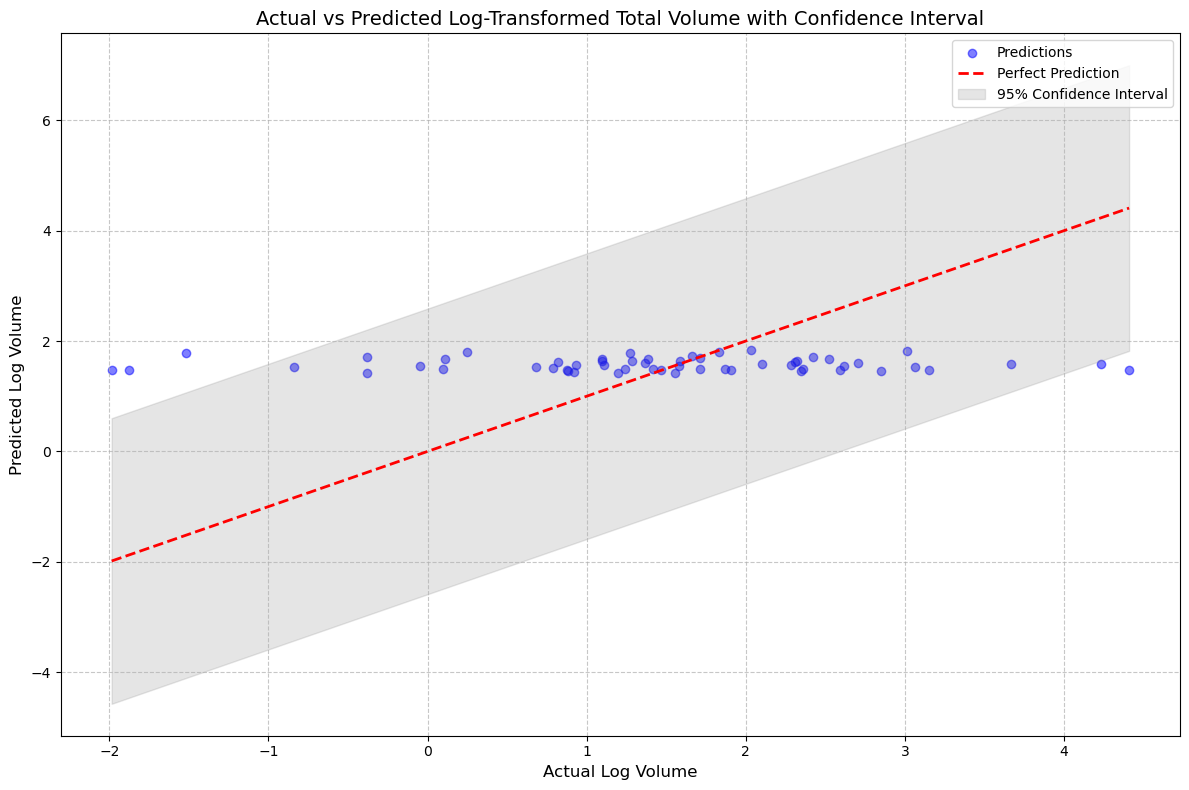

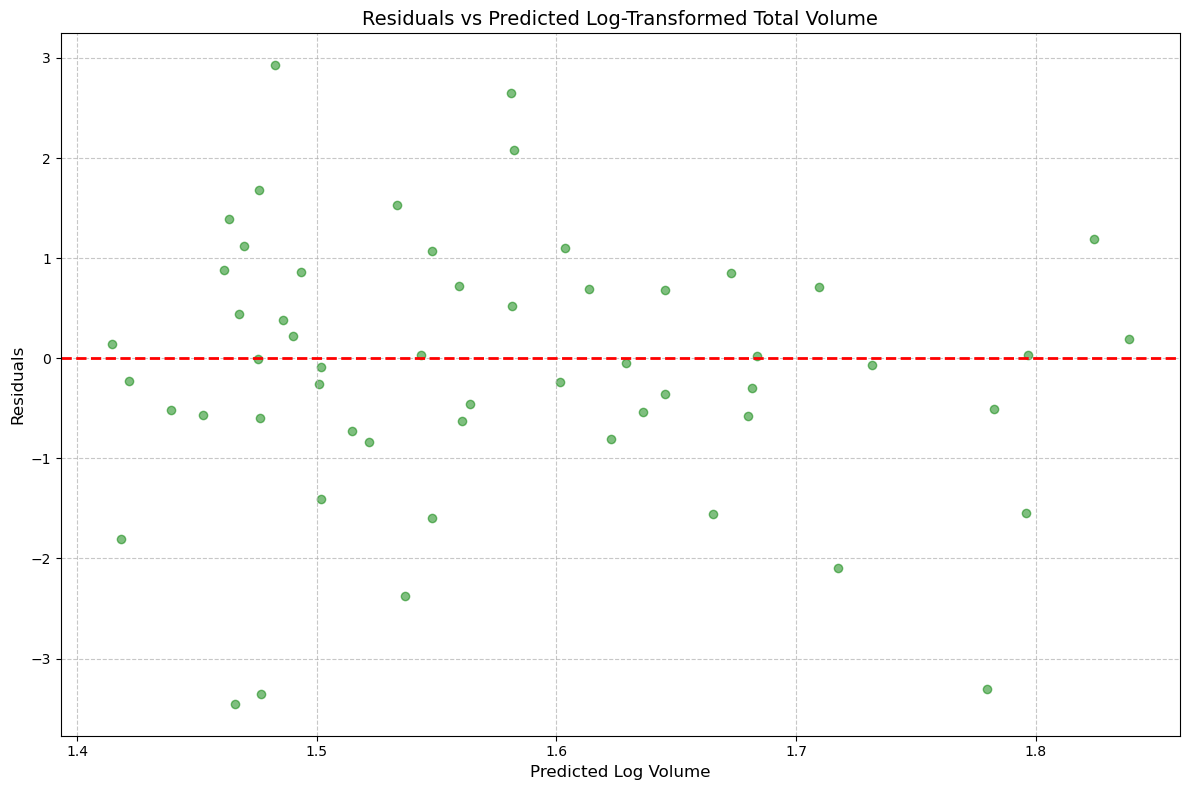

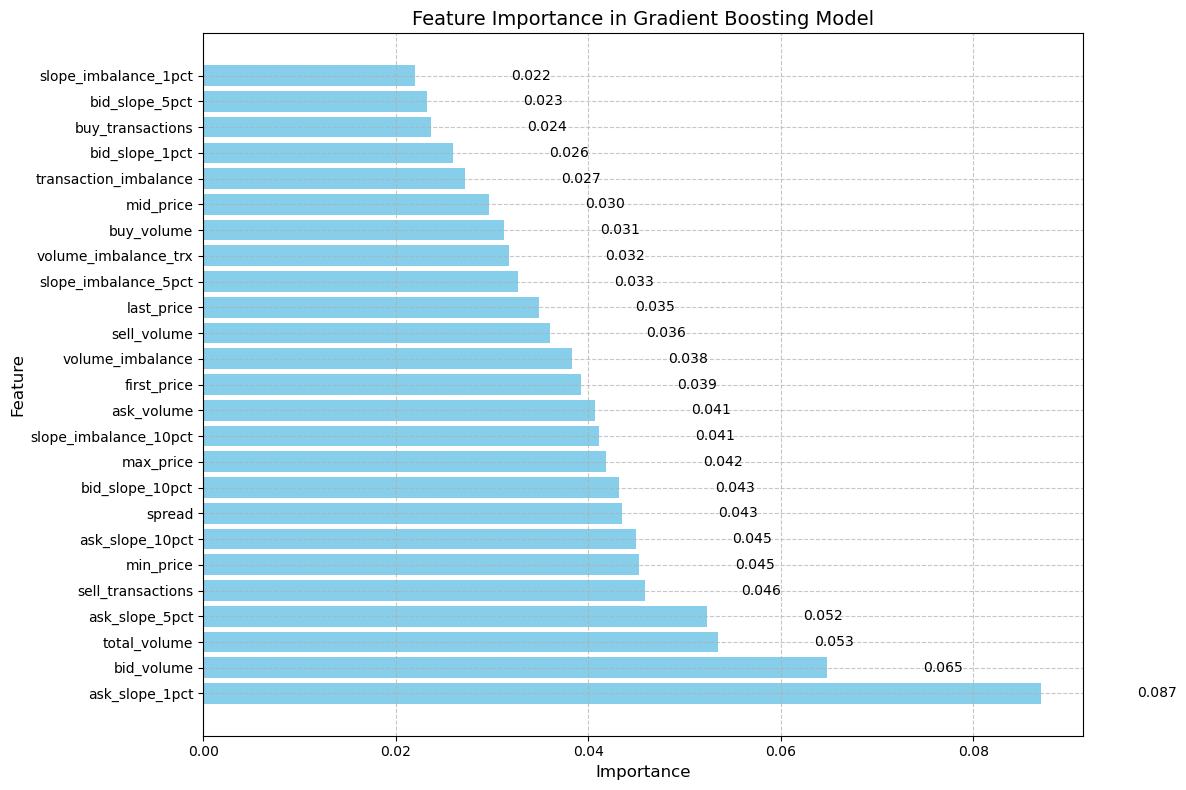

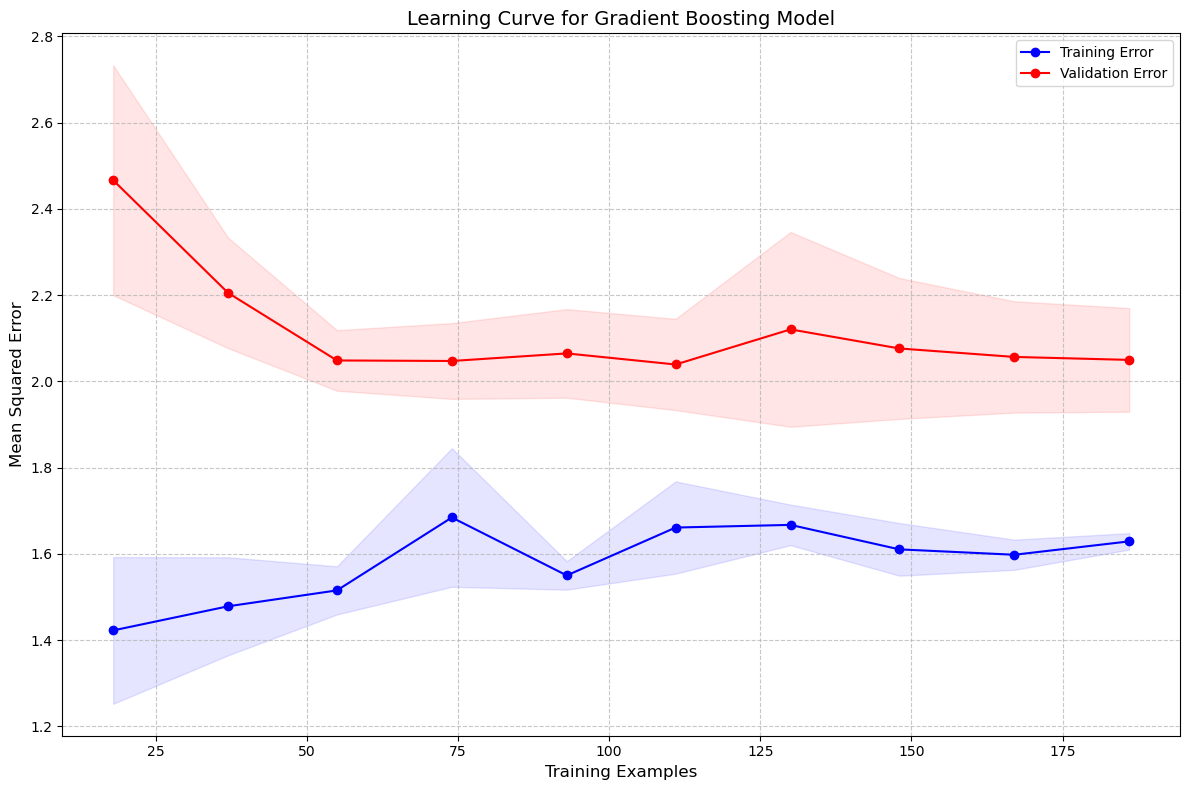

In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming merged_features is your DataFrame (281 rows × 31 columns as per your snippet)
# Verify the DataFrame
print("DataFrame shape:", merged_features.shape)
print("Columns:", merged_features.columns)
print("NaN count in log_deseasoned_total_volume:", merged_features['log_deseasoned_total_volume'].isnull().sum())

# Prepare the target variable (Y) as log_deseasoned_total_volume
Y = merged_features['log_deseasoned_total_volume']

# Prepare the feature matrix (X) by dropping non-feature and non-numeric columns
X = merged_features.drop(columns=['timestamp_id', 'datetime', 'datetime_trx', 'timestamp_id_trx'])

# Ensure all remaining columns are numeric
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'datetime64[ns]':
        raise ValueError(f"Column {col} contains non-numeric data: {X[col].dtype}")

# Drop any rows with NaN values in X or Y
merged_features_cleaned = merged_features.dropna(subset=X.columns.tolist() + ['log_deseasoned_total_volume'])
X = merged_features_cleaned.drop(columns=['timestamp_id', 'datetime', 'datetime_trx', 'timestamp_id_trx','log_deseasoned_total_volume'])
Y = merged_features_cleaned['log_deseasoned_total_volume']

print("Cleaned DataFrame shape:", X.shape)
print("NaN count after cleaning:", X.isnull().sum().sum())

# Split the data based on timestamps (70% train, 10% validation, 20% test)
n_samples = len(merged_features_cleaned)
train_size = int(0.7 * n_samples)  # 70% for training
val_size = int(0.1 * n_samples)    # 10% for validation
test_size = n_samples - train_size - val_size  # 20% for testing

# Sort by datetime to ensure chronological split
merged_features_cleaned = merged_features_cleaned.sort_values('datetime')

# Split into train, validation, and test sets
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]
X_val = X.iloc[train_size:train_size + val_size]
Y_val = Y.iloc[train_size:train_size + val_size]
X_test = X.iloc[train_size + val_size:]
Y_test = Y.iloc[train_size + val_size:]

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),  # [100, 200, ..., 1000]
    'max_features': np.linspace(0.1, 1.0, 10),  # [0.1, 0.2, ..., 1.0]
    'min_samples_leaf': np.arange(2, 10),       # [2, 3, ..., 9]
    'max_depth': np.arange(4, 10),              # [4, 5, ..., 9]
    'learning_rate': np.linspace(0.005, 0.05, 10)  # [0.005, 0.008, ..., 0.05]
}

# Initialize the GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    gbm, param_distributions=param_dist, n_iter=20, cv=3, scoring='neg_mean_squared_error',
    random_state=42, n_jobs=-1, verbose=1, error_score='raise'
)

# Fit the random search on the training + validation data
random_search.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

# Get the best model
best_gbm = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

# Train the best model on the full training set (train + val)
best_gbm.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

# Predict on the test set
Y_pred = best_gbm.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")
print(f"R-squared Score on Test Set: {r2:.4f}")

# Fancy Plots

# 1. Enhanced Predicted vs. Actual Plot with Confidence Intervals
plt.figure(figsize=(12, 8))
plt.scatter(Y_test, Y_pred, color='blue', alpha=0.5, label='Predictions')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2, label='Perfect Prediction')

# Simulate confidence intervals (using standard deviation of residuals)
residuals = Y_test - Y_pred
std_residuals = np.std(residuals)
confidence_interval = 1.96 * std_residuals  # 95% confidence interval
plt.fill_between([Y_test.min(), Y_test.max()], 
                 [Y_test.min() - confidence_interval, Y_test.max() - confidence_interval],
                 [Y_test.min() + confidence_interval, Y_test.max() + confidence_interval],
                 color='gray', alpha=0.2, label='95% Confidence Interval')

plt.xlabel("Actual Log Volume", fontsize=12)
plt.ylabel("Predicted Log Volume", fontsize=12)
plt.title("Actual vs Predicted Log-Transformed Total Volume with Confidence Interval", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Residual Plot
plt.figure(figsize=(12, 8))
plt.scatter(Y_pred, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Log Volume", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Predicted Log-Transformed Total Volume", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Feature Importance Plot
feature_importance = best_gbm.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance in Gradient Boosting Model", fontsize=14)
for i, v in enumerate(feature_importance_df['Importance']):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_gbm, X, Y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error', random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, label='Training Error', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation Error', color='red', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.1)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("Mean Squared Error", fontsize=12)
plt.title("Learning Curve for Gradient Boosting Model", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()